In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder, DatasetFolder

import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                     transforms.Resize((128,128))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset

In [3]:
test_set = load_dataset('./test_set')
class_names = os.listdir('./test_set')
class_names.sort()
num_classes = len(class_names)
test_loader = DataLoader(test_set, batch_size=500, shuffle=False, drop_last=False)
print(class_names)

['Cloth_mask', 'Mask_worn_incorrectly', 'N95_mask', 'No_mask', 'Surgical_mask']


In [4]:
class CNN(nn.Module):  #CNN 
    def __init__(self, num_classes, first_pooling=True, deeper=False):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU()   
            )  
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.conv_layer2_without_pooling = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.pooling = nn.MaxPool2d(2, 2, 0)
        self.deeper_layer = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()    
        )
        out_channels = 256 if deeper else 128
        self.deeper = deeper
        self.first_pooling = first_pooling
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc_layer = nn.Sequential(nn.Linear(out_channels * 7 * 7, 250),
                        nn.Linear(250, num_classes))

    def forward(self, x):
        out = self.conv_layer1(x)
        if self.first_pooling:
          out = self.pooling(out)
          out = self.conv_layer2(out)
        else:
          out = self.conv_layer2_without_pooling(out)
        if self.deeper:
          out = self.pooling(out)
          out = self.deeper_layer(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc_layer(out)

In [5]:
def evaluate_model(model, data_loader):
    model.to('cpu')
    predictions = torch.tensor([])
    targets = torch.tensor([])
    
    for i, (images, labels) in enumerate(data_loader):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    print('accuracy: %.2f%% f1 score: %.3f precision: %.3f recall: %.3f' % (accuracy, f1, precision, recall))
    conf_matrix = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, cmap='Blues');
    return conf_matrix,[accuracy, f1, recall, precision]

accuracy: 70.20% f1 score: 0.704 precision: 0.712 recall: 0.702


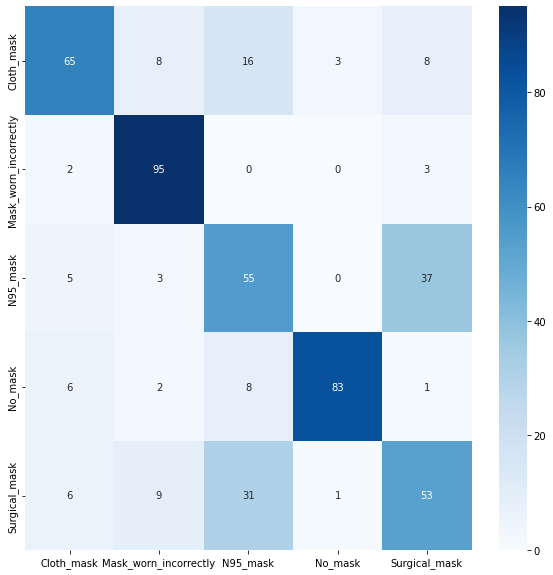

In [6]:
normal_CNN = CNN(5)
normal_CNN.load_state_dict(torch.load('normal-CNN-model.pt'))
evaluate_model(normal_CNN, test_loader)
normal_CNN = None

accuracy: 73.00% f1 score: 0.733 precision: 0.745 recall: 0.730


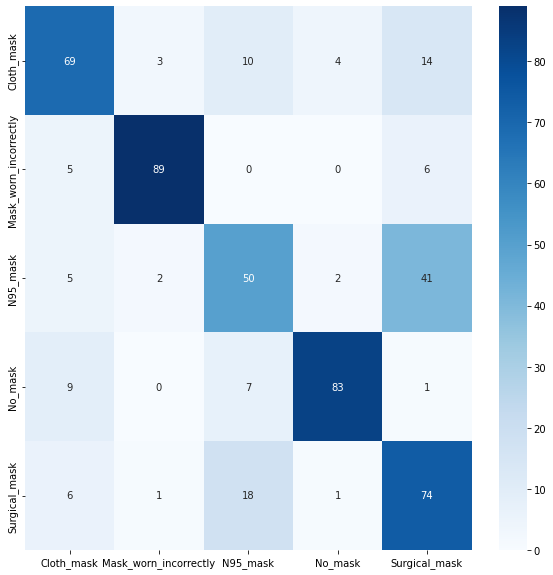

In [7]:
CNN_less_pooling = CNN(5, False)
CNN_less_pooling.load_state_dict(torch.load('CNN-less-pooling-model.pt'))
evaluate_model(CNN_less_pooling, test_loader)
CNN_less_pooling = None

accuracy: 74.80% f1 score: 0.746 precision: 0.747 recall: 0.748


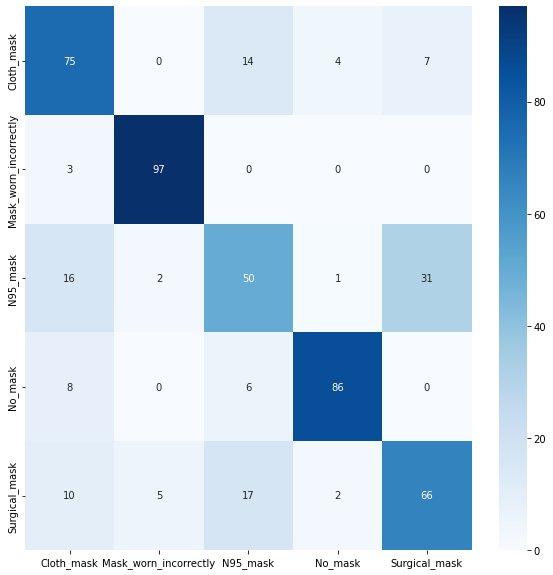

In [8]:
deeper_CNN = CNN(5, False, True)
deeper_CNN.load_state_dict(torch.load('deeper-CNN-model.pt'))
evaluate_model(deeper_CNN, test_loader)
deeper_CNN = None